In this notebook we train a model on the 17flowers dataset - classifying the flowers

# Imports

In [1]:
from pathlib import Path

import json
# import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from collections import Counter

# Load data

In [2]:
DATASET_FOLDER = Path("flowers/data_17flowers/")

In [3]:
df = pd.read_csv("flowers/data_labels.csv")
df.head()

,image,label,is_valid
0,image_0001.jpg,Daffodil,True
1,image_0002.jpg,Daffodil,True
2,image_0003.jpg,Daffodil,True
3,image_0004.jpg,Daffodil,True
4,image_0005.jpg,Daffodil,True


### Sizes of images

In [4]:
%%time
sizes = [Image.open(DATASET_FOLDER / image).size for image in df.image]
Counter(sizes)

CPU times: user 208 ms, sys: 4 ms, total: 212 ms
Wall time: 208 ms


Counter({(689, 500): 2,
         (666, 500): 258,
         (500, 704): 2,
         (749, 500): 3,
         (555, 500): 3,
         (750, 500): 24,
         (516, 500): 1,
         (536, 500): 1,
         (671, 500): 2,
         (500, 666): 68,
         (665, 500): 18,
         (499, 743): 1,
         (500, 544): 1,
         (517, 500): 4,
         (553, 500): 1,
         (505, 500): 5,
         (541, 500): 1,
         (500, 554): 2,
         (592, 500): 2,
         (667, 500): 13,
         (509, 500): 3,
         (500, 574): 2,
         (500, 513): 3,
         (500, 670): 1,
         (499, 754): 1,
         (574, 500): 2,
         (500, 612): 3,
         (500, 729): 1,
         (753, 500): 3,
         (500, 760): 4,
         (500, 520): 2,
         (500, 582): 3,
         (599, 500): 2,
         (542, 500): 2,
         (747, 500): 1,
         (664, 500): 3,
         (623, 500): 1,
         (737, 500): 3,
         (500, 515): 2,
         (625, 500): 16,
         (500, 700): 6,
         

### Databunch

In [5]:
img_size = (500, 500)
batch_size=16 #64
partial_pct=1 #0.01
np.random.seed(273)

In [6]:
src = (ImageList.from_df(df, cols="image", path=DATASET_FOLDER)
       .use_partial_data(partial_pct)
       .split_from_df("is_valid")
       .label_from_df(cols="label"))

tfms = get_transforms()  # TODO
data = (src.transform(tfms, size=img_size, padding_mode ="zeros")
        .databunch(bs=batch_size).normalize(imagenet_stats))

In [7]:
data

ImageDataBunch;

Train: LabelList (1156 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
Cowslip,Daisy,Cowslip,Iris,Buttercup
Path: flowers/data_17flowers;

Valid: LabelList (204 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
Bluebell,Windflower,Bluebell,Bluebell,Crocus
Path: flowers/data_17flowers;

Test: None

## ResNet50 model

In [20]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])
learn.model_dir = "model" #"/kaggle/working/model"

#### frozen training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


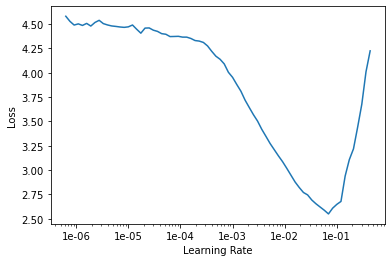

In [21]:
learn.lr_find()
fig = learn.recorder.plot(return_fig=True)

In [22]:
initial_lr = 2e-03
lr_slice = slice(initial_lr)
n_epochs = 2

In [23]:
learn.fit_one_cycle(n_epochs, lr_slice)

epoch,train_loss,valid_loss,accuracy,time
0,1.127511,0.287968,0.921569,01:33
1,0.465259,0.215605,0.936275,01:34


#### unfrozen training

In [24]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


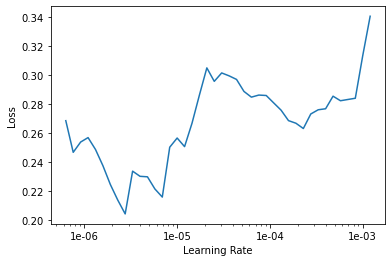

In [25]:
learn.lr_find()
fig = learn.recorder.plot(return_fig=True)

In [26]:
# initial_lr = 2e-03
lr = 1e-06
lr_end = initial_lr / 10
lr_slice = slice(lr, lr_end)
n_epochs = 4

In [27]:
learn.fit_one_cycle(n_epochs, lr_slice)

epoch,train_loss,valid_loss,accuracy,time
0,0.222214,0.200490,0.936275,02:04
1,0.162252,0.144920,0.950980,02:04
2,0.112690,0.179930,0.941176,02:04
3,0.083830,0.149558,0.960784,02:04


# interp

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

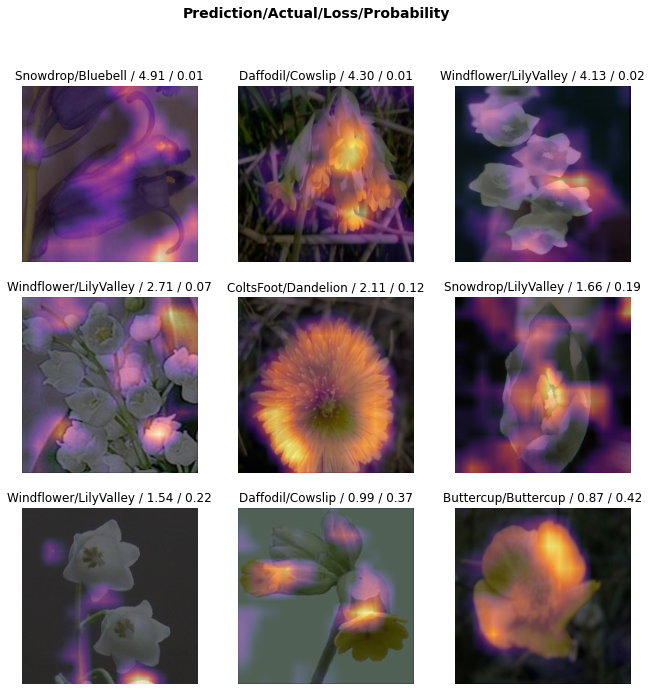

In [30]:
interp.plot_top_losses(9, figsize=(11,11), heatmap=True)

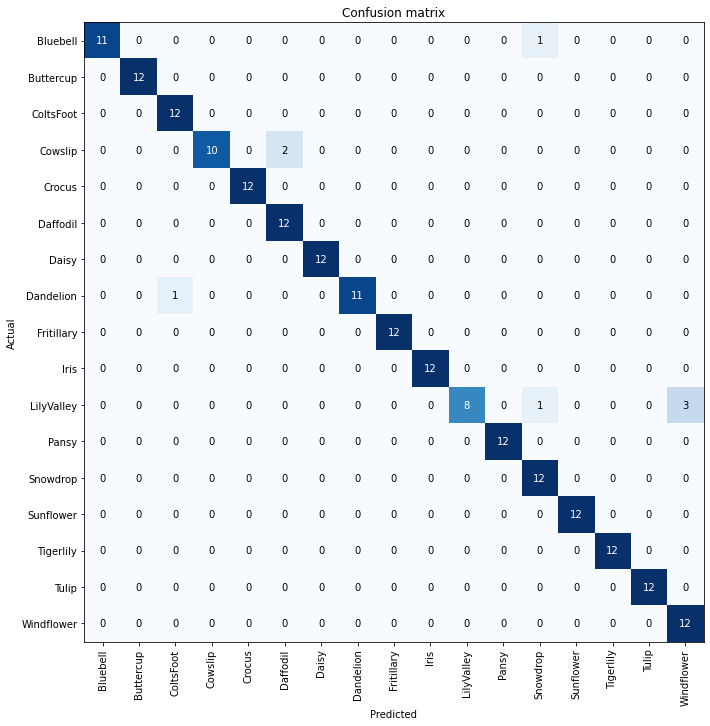

In [32]:
interp.plot_confusion_matrix(figsize=(10,10)) #, dpi=60)

In [35]:
12*17

204

In [34]:
(12*17 - 8) / (12 * 17)

0.9607843137254902

So we missed 8 out of 204 images

In [37]:
learn.export("flowers.pkl")

In [38]:
learn.save("flowers")